In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Simple Analysis

Load data 

In [ ]:
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
!pip install keras-layer-normalization
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# just to ignore the matplotlib warnings to make the plots look better
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=49206bcc3cffa857bc73b1238d95b99c086a5ef65dddb299b3a32b7e555d7458
  Stored in directory: /root/.cache/pip/wheels/85/5d/1c/2e619f594f69fbcf8bc20943b27d414871c409be053994813e
Successfully built keras-layer-normalization


In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

In [ ]:
#Helper function
#TODO: pick more collumns to use
def load_data(split_name='train', columns=['text', 'stars'], folder='drive/Comp 4332/Project 1/data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.
        
        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "stars" column is the labels (sentiment). 
        If you like, you are free to use columns other than "text" for prediction.
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/COMP4332/Project 1/data'
train_df = load_data('train', columns=['text', 'stars','cool','funny'], folder=data_dir)
valid_df = load_data('valid', columns=['text', 'stars','cool','funny'], folder=data_dir)
# the test set labels (the 'stars' column) are not available! So the following code will instead return all columns
test_df = load_data('test', columns=['text', 'stars'], folder=data_dir)

select [text, stars, cool, funny] columns from the train split
Success
select [text, stars, cool, funny] columns from the valid split
Success
select [text, stars] columns from the test split
Failed loading specified columns... Returning all columns from the test split


Start process data

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

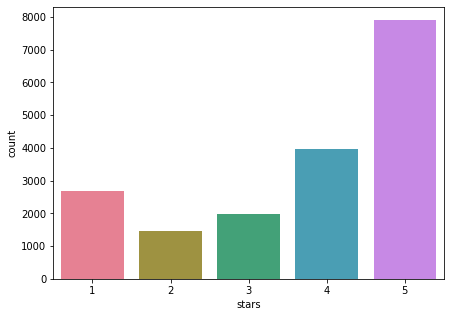

In [ ]:
plt.figure(figsize = (7,5))
sns.countplot('stars', data = train_df, palette="husl")

In [ ]:
train_df['Words count'] = train_df['text'].apply(lambda x:len(x.split()))

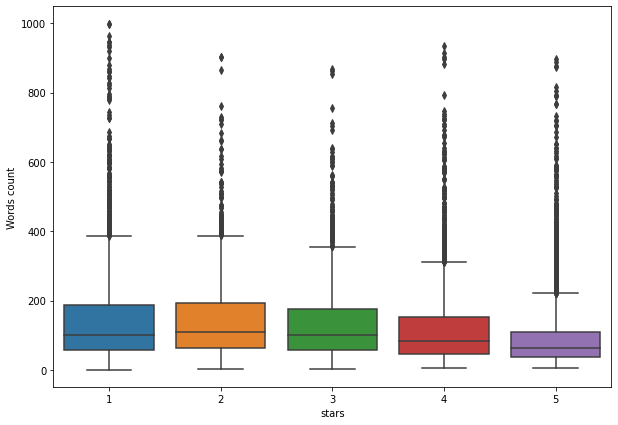

In [ ]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'stars', y = 'Words count', data = train_df)

In [ ]:
!pip install afinn

     |████████████████████████████████| 52 kB 1.0 MB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=d8b071587a87738ef9c4389fc0c1eb10ba8fdb550b0092299e582405c9697a41
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [ ]:
from afinn import Afinn
afinn = Afinn(language='en')

In [ ]:
train_df['Afinn score'] = train_df['text'].apply(lambda x:afinn.score(x))

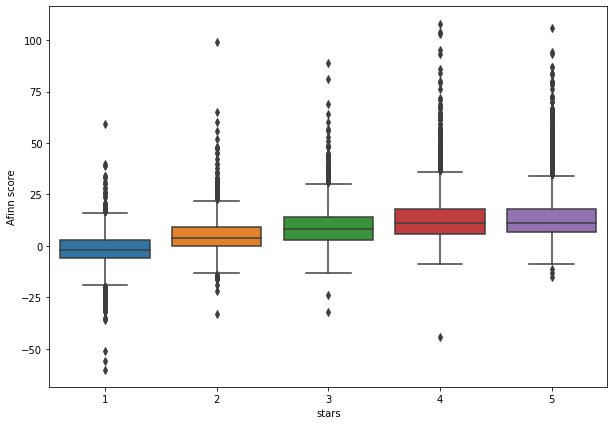

In [ ]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'stars', y = 'Afinn score', data = train_df)

# Tokenize data and remove stop words

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token=='not' or token not in stopwords and not token.isnumeric()]

import numpy as np

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_df['tokens'] = train_df['text'].map(tokenize).map(filter_stopwords).map(lower)
print(list(test_df.columns)) #added col "token"
print(train_df['tokens'].head().to_string())

['business_id', 'cool', 'date', 'funny', 'review_id', 'text', 'useful', 'user_id']
0    [i, 've, handful, times, i, 've, never, disapp...
1    [the, service, terrible, ., the, food, ok., de...
2    [alil, pricey, location, completly, get, bang,...
3    [do, n't, get, car, washed, ., paid, car, came...
4    [cute, tight, ., not, expensive, creative, ., ...


In [ ]:
valid_df['tokens'] = valid_df['text'].map(tokenize).map(filter_stopwords).map(lower)
print(list(test_df.columns)) #added col "token"
print(valid_df['tokens'].head().to_string())

['business_id', 'cool', 'date', 'funny', 'review_id', 'text', 'useful', 'user_id']
0    [we, came, today, closing, &, still, allowed, ...
1    [tiny, ,, casual, location, breakfast/brunch, ...
2    [we, keep, going, plaza, eat, pizza, i, wanted...
3    [tim, hortons, epitome, canadian, mediocrity, ...
4    [workers, friendly, know, lions, well, !, i, g...


Analyze positive and negative words

In [ ]:
path = 'drive/MyDrive/Colab Notebooks/COMP4332/Project 1/data/'

In [ ]:
list_positive=[]
list_negative=[]

In [ ]:
with open(path+'positive-words.txt') as f:
    lines = f.readlines()
    for word in lines:
      word= word.rstrip()
      list_positive.append(word)

In [ ]:
with open(path+'negative-word.txt') as f:
    lines = f.readlines()
    for word in lines:
      word= word.rstrip()
      list_negative.append(word)

In [ ]:
def count_positive(text):
  count =0;
  for word in text:
    if word in list_positive:
      count=count+1
  return count

In [ ]:
def count_negative(text):
  count =0;
  for word in text:
    if word in list_negative:
      count=count+1
  return count

In [ ]:
train_df['positive'] = train_df['tokens'].map(count_positive)
train_df['negative'] = train_df['tokens'].map(count_negative)

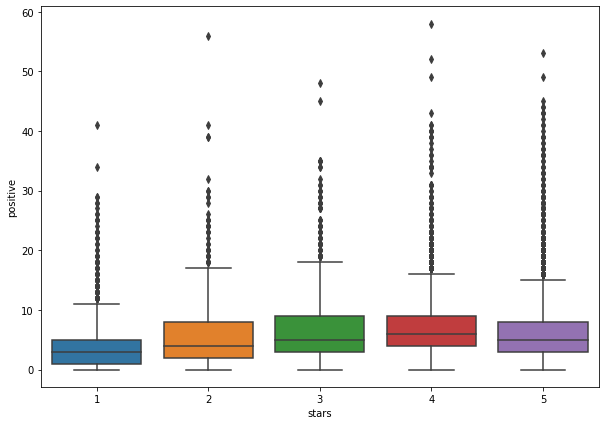

In [ ]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'stars', y = 'positive', data = train_df)

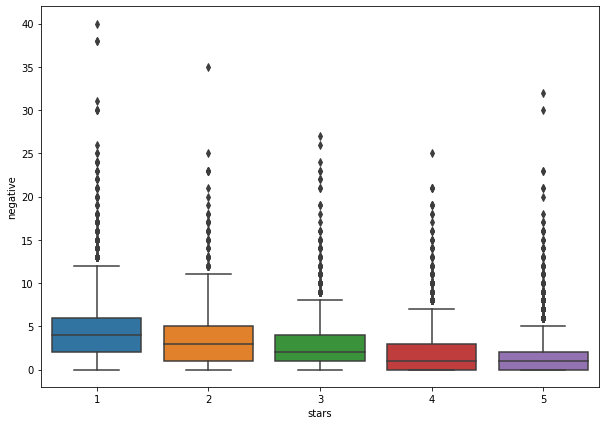

In [ ]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'stars', y = 'negative', data = train_df)

# Other attribute (funny and cool)

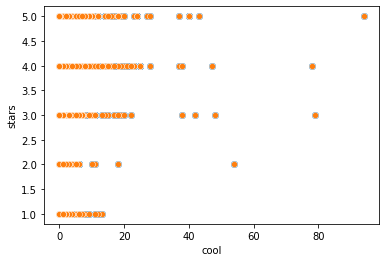

In [ ]:
plt.scatter(train_df['cool'], train_df['stars'])
sns.scatterplot(data=train_df, x="cool", y="stars")

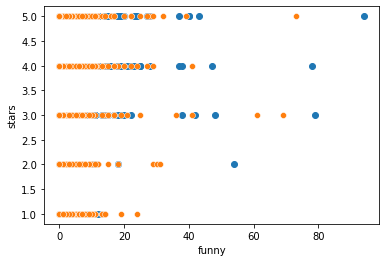

In [ ]:
plt.scatter(train_df['cool'], train_df['stars'])
sns.scatterplot(data=train_df, x="funny", y="stars")

# World Cloud

In [ ]:
from collections import Counter
from wordcloud.wordcloud import WordCloud, STOPWORDS

# let see which words exist the most in each 'voting' class
most_common_words = [[] for i in range(5)]

for v in range(1,6):
    corpus = ' '.join(train_df['text'][train_df['stars'] == v].to_list())
    bow = corpus.lower().split(' ')
    count_list = Counter(bow)
    print('-'*10, 'voting {}'.format(v), '-'*10)
    for w, c in count_list.most_common(200):
        if w not in STOPWORDS: # stopwords.words('english'):
            #print(w, c)
            most_common_words[v-1].append(w)

---------- voting 1 ----------
---------- voting 2 ----------
---------- voting 3 ----------
---------- voting 4 ----------
---------- voting 5 ----------


In [ ]:
bow = []
for i in range(5):
    bow += most_common_words[i]
count_list = Counter(bow)
for w,c in count_list.most_common():
    #print(w, c)
    pass

In [ ]:
for i in range(5):
    for j in range(i+1,5):
        print(i,j)
        mcw_i = most_common_words[i]
        mcw_j = most_common_words[j]
        print('set {} minus set {}'.format(i+1,j+1), set(mcw_i).difference(mcw_j))
        print('set {} minus set {}'.format(j+1,i+1), set(mcw_j).difference(mcw_i))

0 1
set 1 minus set 2 {'customer', 'called', 'need', 'gave', 'business', 'walked', 'service.', 'manager', 'front', 'pay', 'put', 'worst', 'rude', 'tell', 'again.', 'waiting', 'day', 'getting', 'work', 'money', 'me.', 'phone', 'looked', 'call', 'hour', 'car', 'someone', 'finally'}
set 2 minus set 1 {'sauce', 'tasted', 'menu', 'pretty', 'least', 'something', 'find', 'bit', 'small', 'always', 'eat', 'look', 'location', 'table', 'lot', 'long', 'though', 'server', 'nice', 'maybe', 'food.', 'taste', 'good.', '\n\nthe', 'many', 'well', 'little', 'thing', 'great', 'half', 'quality'}
0 2
set 1 minus set 3 {'called', 'service.', 'left', 'now', 'ask', 'put', 'tell', 'check', 'waiting', 'last', 'getting', 'money', 'me.', 'phone', 'looked', 'call', 'car', 'someone', 'wanted', 'customer', 'gave', 'business', 'walked', 'manager', 'front', 'pay', 'worst', 'rude', 'told', 'again.', 'day', 'work', 'times', 'hour', 'finally'}
set 3 minus set 1 {'definitely', 'pizza', 'menu', 'eat', 'bar', 'table', 'decen



```
# This is formatted as code
```

#  TSNE Plot

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#data
# Prepare the data.
# As an example, we only use the text data. 
x_train = train_df['text']
y_train = train_df['stars']#.apply(lambda x: 3 if (2 <= x and x <= 4) else x)

x_valid = valid_df['text']
y_valid = valid_df['stars']#.apply(lambda x: 3 if (2 <= x and x <= 4) else x)

x_test = test_df['text']

In [ ]:
def plot_scatter(tsne_data, colors):
    # choose a color palette with seaborn.
    tsne_data = np.vstack((tsne_data.T, colors)).T
    tsne_df = pd.DataFrame(data = tsne_data,
         columns =("Dim_1", "Dim_2", "label"))
      
    # Ploting the result of tsne
    sns.FacetGrid(tsne_df, hue ="label", size = 6).map(
           plt.scatter, 'Dim_1', 'Dim_2').add_legend()
      
    plt.show()

x_tsne [[-52.746933  111.235985 ]
 [ 16.633492   -9.279526 ]
 [  3.7891452 -77.815994 ]
 ...
 [-25.561615   -3.1387684]
 [  0.9686232 -92.64807  ]
 [-41.25421   -98.96368  ]]
y [5 4 4 ... 5 5 5]


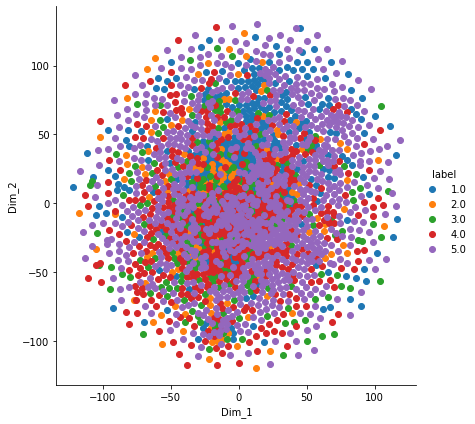

In [ ]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf.fit(x_train)
x_embeds = tfidf.transform(x_valid)

x_tsne = TSNE().fit_transform(x_embeds)
y = np.array(y_valid)
print('x_tsne',x_tsne)
print('y',y)

plot_scatter(x_tsne, y)
# too many data of high dimension -> tSNE plot is not meaningful

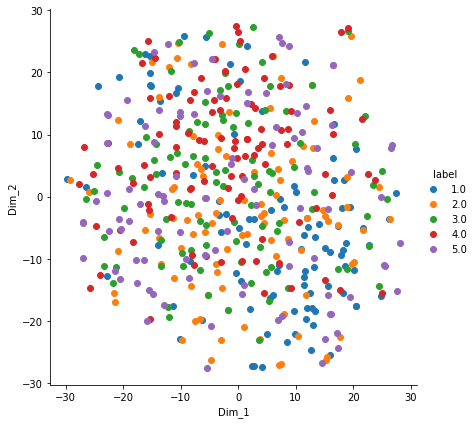

In [ ]:
# use smaller set of data
aggre_df = pd.DataFrame({'text':[], 'stars':[]})
num_per_class = 100

for s in range(1,6):
    temp = train_df[train_df['stars']==s]
    aggre_df = aggre_df.append(temp[:num_per_class])

x_embeds = tfidf.transform(aggre_df['text'])

x_tsne = TSNE().fit_transform(x_embeds)
y = np.array(aggre_df['stars'])

plot_scatter(x_tsne, y)
# still very chaostic